In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import bilby
import corner 
import seaborn as sns
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch
%matplotlib inline

In [74]:
def get_lambda_antisymmetric(result):
    result.posterior['lambda_antisymmetric'] = 0.5*(result.posterior['lambda_2']-result.posterior['lambda_1'])
    result.injection_parameters['lambda_antisymmetric'] = 0.5*(result.injection_parameters['lambda_2']-result.injection_parameters['lambda_1'])
    return 
def get_lambda_symmetric(result):
    result.posterior['lambda_symmetric'] = 0.5*(result.posterior['lambda_2']+result.posterior['lambda_1'])
    result.injection_parameters['lambda_symmetric'] = 0.5*(result.injection_parameters['lambda_2']+result.injection_parameters['lambda_1'])
    return 
def get_lambda_symmetric_inj(result):
    result.injection_parameters['lambda_symmetric'] = 0.5*(result.injection_parameters['lambda_2']+result.injection_parameters['lambda_1'])
    return 


def get_lambda_tilde(result):
    result.posterior['lambda_tilde'] = bilby.gw.conversion.lambda_1_lambda_2_to_lambda_tilde(result.posterior['lambda_1'], result.posterior['lambda_2'], result.posterior['mass_1_source'],result.posterior['mass_2_source'])
    return 

def get_lambda_1_lambda_2(result):
    result.posterior['lambda_1'], result.posterior['lambda_2'] = bilby.gw.conversion.binary_love_lambda_symmetric_to_lambda_1_lambda_2_manual_marginalisation(result.posterior['binary_love_uniform'], result.posterior['lambda_symmetric'], result.posterior['mass_ratio'])
    return
    
def get_quantile_from_samples(x, target=0, twosided=False):
    ''' Get quantile (one or two-sided) of target value from samples.

    Arguments
    ---------
    x: array
        array of samples.
    target: float
        x value for which to compute quantile (def. 0).
    twosided: bool
        whether to compute two-sided quantile (def. False).

    Returns
    -------
    q: float
       quantile at target.
    '''
    if twosided:
        abs_dist = np.abs(x - np.median(x))
        target_dist = np.abs(target - np.median(x))
        q = len(abs_dist[abs_dist <= target_dist]) / len(x)
    else:
        q =len(x[x <= target])/len(x)
    return q

    
def get_quantile_from_samples_multi(x, target=0, twosided=False):
    ''' Get quantile (one or two-sided) of target value from samples.

    Arguments
    ---------
    x: array
        array of samples.
    target: float
        x value for which to compute quantile (def. 0).
    twosided: bool
        whether to compute two-sided quantile (def. False).

    Returns
    -------
    q: float
       quantile at target.
    '''
    if twosided:
        abs_dist = np.abs(x - np.median(x))
        target_dist = np.abs(target - np.median(x))
        q = len(abs_dist[abs_dist <= target_dist]) / len(x)
    else:
        q = np.mean(np.all(samples <= target, axis=1))
    return q

def quantile_factor(samples, parameter, twosided=False):
    x = samples.posterior[f'{parameter}']
    target = samples.injection_parameters[f'{parameter}']
    return 0.5 - get_quantile_from_samples(x, target, twosided)

def quantile_multi(samples, parameters, twosided=False):
    x = [samples.posterior[f'{parameters[i]}'] for i in range(len(parameters))]
    target = [samples.injection_parameters[f'{parameters[i]}'] for i in range(len(parameters))]
    return 0.5 - get_quantile_from_samples(x, target, twosided)

def Ceff(C1, C2, m1, m2, chi1, chi2):
    return (C1 * m1**2 * chi1**2 + C2 * m2**2 * chi2**2)/(m1+m2)**2

def get_Ceff(result):
    result.injection_parameters['Ceff'] = Ceff(result.injection_parameters['dquadmod1'], result.injection_parameters['dquadmod2'],result.injection_parameters['mass_1_source'], result.injection_parameters['mass_2_source'], result.injection_parameters['chi_1'], result.injection_parameters['chi_2'])
    result.posterior['Ceff'] = Ceff(result.posterior['dquadmod1'], result.posterior['dquadmod2'],result.posterior['mass_1_source'], result.posterior['mass_2_source'], result.posterior['chi_1'], result.posterior['chi_2'])
    return

def get_Ceff_UR(result):
    C1 = get_quadrupole_UR(result.injection_parameters['lambda_1'])
    C2 = get_quadrupole_UR(result.injection_parameters['lambda_2'])
    result.injection_parameters['Ceff_UR'] = Ceff(C1, C2,result.injection_parameters['mass_1_source'], result.injection_parameters['mass_2_source'], result.injection_parameters['chi_1'], result.injection_parameters['chi_2'])
    return

def get_quadrupole_UR(L):
    return np.exp(0.1940 + 0.09163*np.log(L) + 0.04812*np.log(L)**2 - 4.283e-3*np.log(L)**3+1.245e-4*np.log(L)**4)

def get_f2_from_Lambda_UR_SI(Lambda, M):
    '''
    Calculates (quadrupolar) f-mode frequency though UR as in Sotani & Kumar (2021)
    https://arxiv.org/pdf/2109.08145
    
    Inputs:
    Lambda - (quadrupolar) Dimensionless tidal deformability
    M - Mass [Solar Masses]

    Outputs:
    f-mode frequency [Hz]
    '''
    g = [4.2590, -0.47874, -0.45353, 0.14439, -0.016194, 0.00064163]
    UR = 0.
    for i ,g_i in enumerate(g):
        UR+=g_i*(np.log10(Lambda))**i
    return UR*(1.4/M)*1000



In [75]:
#Matplotlib Parameters
plt.rcParams['axes.linewidth'] = 1.75

fs = 24
rc_params = {'backend': 'pdf',
             'axes.labelsize': fs,
             'axes.titlesize': 32,
             'font.size': fs-4,
             'legend.fontsize': fs-4,
             'xtick.labelsize': fs,
             'ytick.labelsize': fs,
             'font.family': 'serif',
             'font.sans-serif': ['Bitstream Vera Sans'],
             'font.serif': ['Times New Roman'],
             'text.latex.preamble': r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{amsfonts}',
             'text.usetex':True,
             'lines.linewidth': 3,
             'mathtext.fontset': 'cm'
            }

plt.rcParams["patch.force_edgecolor"] = True

plt.rcParams.update(rc_params)

In [ ]:

eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/soft_mrlfmode.dat') 
eos_f2 = eos_data[:,3]*1000

soft_fmode_interp = ius(eos_mass, eos_f2)

eos_data = np.loadtxt('/work/williams5/testing-urs/EOS/stiff_mrlfmode.dat')

eos_mass = eos_data[:,1]
eos_f2 = eos_data[:,3]*1000
stiff_fmode_interp = ius(eos_mass, eos_f2)

In [77]:
catalog = pd.read_csv('/work/williams5/testing-urs/bilby/scripts/top_50_fixedQ.csv')
maxSNR = np.max(catalog['SNR'])
figdir = '/work/williams5/testing-urs/bilby/figs'
baserundir = '/work/williams5/testing-urs/bilby/runs'

In [78]:
N = 20

## Quadrupole moment

### Zero noise

In [79]:
catalog = pd.read_csv('/work/williams5/testing-urs/bilby/scripts/top_50_fixedQ.csv')
maxSNR = np.max(catalog['SNR'])
soft_sampleQ = {}
soft_QUR = {}
stiff_sampleQ = {}
stiff_QUR = {}
soft_stan = {}
stiff_stan = {}
missing = []
N = 10
j=0
for i in range(10,20):
    try:
        rundir = f'{baserundir}/sampleQ/soft/zero-noise'
        label='sampleQ'
        res_free = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_free)
        get_Ceff(res_free)
        get_Ceff_UR(res_free)
        soft_sampleQ[f'{j}']=res_free
        
        rundir = f'{baserundir}/sampleQUR/soft/zero-noise'
        label='sampleQUR'
        res_UR = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_UR)
        soft_QUR[f'{j}']=res_UR
        
        rundir = f'{baserundir}/sampleQ/stiff/zero-noise'
        label='sampleQ'
        res_free = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_free)
        get_Ceff(res_free)
        get_Ceff_UR(res_free)
        stiff_sampleQ[f'{j}']=res_free
        
        rundir = f'{baserundir}/sampleQUR/stiff/zero-noise'
        label='sampleQUR'
        res_UR = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_UR)
        stiff_QUR[f'{j}']=res_UR

        rundir = f'{baserundir}/standard/soft/zero-noise'
        label='standard'
        stan = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(stan)
        soft_stan[f'{j}']=stan

        rundir = f'{baserundir}/standard/stiff/zero-noise'
        label='standard'
        stan = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(stan)
        stiff_stan[f'{j}']=stan

        j+=1
    except:
        print(f'Could not find sample {rundir}/{i}/{label}, please check')
        missing.append(i)
catalog=catalog.drop(missing)

soft_sampleQ_zn = soft_sampleQ
soft_QUR_zn = soft_QUR 
stiff_sampleQ_zn = stiff_sampleQ
stiff_QUR_zn = stiff_QUR
soft_stan_zn = soft_stan
stiff_stan_zn = stiff_stan

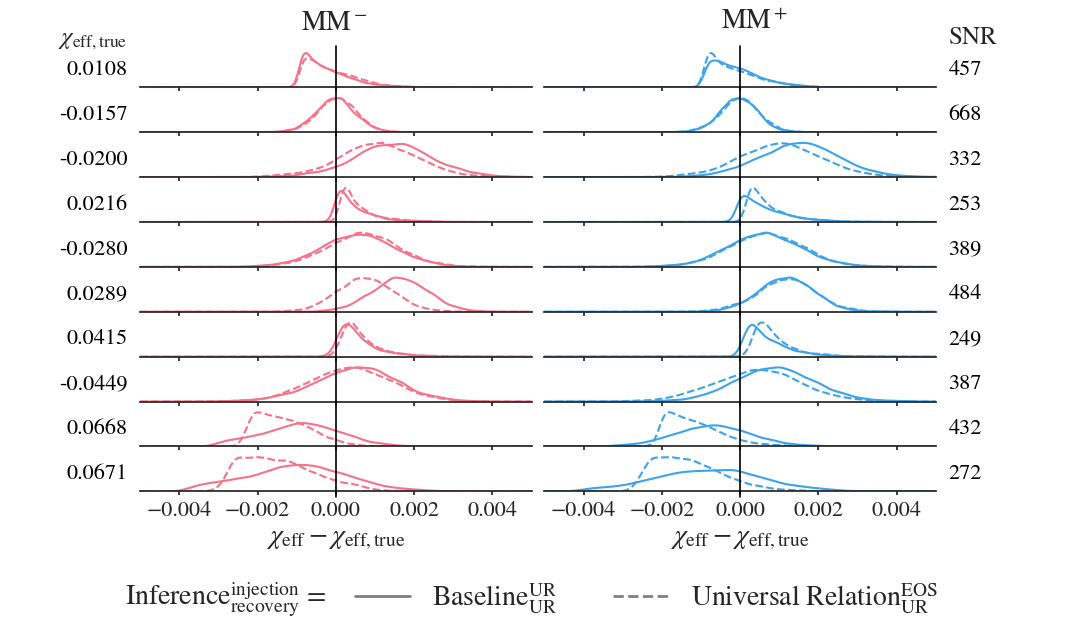

In [ ]:
# --- Style ---
c = sns.husl_palette(3)
sns.set(style='white')
mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral"
})
alpha_val = 0.4

# --- Compute sorting order by abs(true chi_eff) ---
chi_eff_values = {
    idx: abs(soft_sampleQ[str(idx)].injection_parameters.get('chi_eff', float('nan')))
    for idx in range(0, 10)
}
chi_eff_values = {k: v for k, v in chi_eff_values.items() if not np.isnan(v)}
sorted_indices = sorted(chi_eff_values, key=chi_eff_values.get)

# --- Figure ---
fig = plt.figure(figsize=(12, len(sorted_indices)*0.55))
gs = gridspec.GridSpec(
    nrows=len(sorted_indices),
    ncols=4,  # true chi_eff, soft, stiff, SNR
    width_ratios=[0.3,1,1,0.3],
    wspace=0.05
)

# --- Legend ---
legend_elements = [
    Patch(facecolor=c[0], alpha=alpha_val, label=r'Baseline$^{\mathrm{UR}}_{\mathrm{UR}}$'),
    Patch(facecolor=c[2], alpha=alpha_val, label=r'Universal Relation$^{\mathrm{EOS}}_{\mathrm{UR}}$')
]

param = 'chi_eff'
xlim_range = (-0.005, 0.005)
x_grid = np.linspace(*xlim_range, 500)

for i, idx in enumerate(sorted_indices):
    idx_str = str(idx)

    # --- Extract data ---
    soft_q = soft_stan[idx_str].posterior[param]
    soft_qur = soft_QUR[idx_str].posterior[param]
    soft_true = soft_sampleQ[idx_str].injection_parameters[param]

    stiff_q = stiff_stan[idx_str].posterior[param]
    stiff_qur = stiff_QUR[idx_str].posterior[param]
    stiff_true = stiff_sampleQ[idx_str].injection_parameters[param]

    # Center posteriors
    soft_q_c = soft_q - soft_true
    soft_qur_c = soft_qur - soft_true
    stiff_q_c = stiff_q - stiff_true
    stiff_qur_c = stiff_qur - stiff_true

    # --- True chi_eff column ---
    ax_true = fig.add_subplot(gs[i,0])
    ax_true.axis('off')
    ax_true.text(1.0, 0.5, f"{soft_true:.4f}", ha='right', va='center', color='black',
                 transform=ax_true.transAxes, fontsize=fs-8)
    if i == 0:
        ax_true.set_title(r'$\chi_{\mathrm{eff,true}}$', loc='right', fontsize=fs-6)

    # --- Soft EOS column ---
    ax_soft = fig.add_subplot(gs[i,1])
    # Baseline and Universal Relation
    for data, linestyle in zip([soft_q_c, soft_qur_c], ['-', '--']):
        kde = gaussian_kde(data)
        y_vals = kde(x_grid)
        y_vals = np.clip(y_vals, 0, None)
        ax_soft.plot(x_grid, y_vals, color=c[0], linewidth=1.5, linestyle=linestyle)  # only line, no fill
    ax_soft.set_xlim(xlim_range)
    ax_soft.set_ylim(bottom=0)
    ax_soft.set_yticks([])
    ax_soft.spines['top'].set_visible(False)
    ax_soft.spines['right'].set_visible(False)
    ax_soft.spines['left'].set_visible(False)
    ax_soft.tick_params(axis='x', which='both', bottom=True, labelsize=12, length=3)
    if i == len(sorted_indices) - 1:
        ax_soft.set_xlabel(r'$\chi_{\mathrm{eff}} - \chi_{\mathrm{eff,true}}$', fontsize=fs-4)
        ax_soft.tick_params(axis='x', which='both', bottom=True, labelsize=fs-8, length=3)
    else:
        ax_soft.set_xlabel("")
        ax_soft.tick_params(axis='x', which='both', bottom=True, labelsize=0, length=3)

    # --- Stiff EOS column ---
    ax_stiff = fig.add_subplot(gs[i,2])
    for data, linestyle in zip([stiff_q_c, stiff_qur_c], ['-', '--']):
        kde = gaussian_kde(data)
        y_vals = kde(x_grid)
        y_vals = np.clip(y_vals, 0, None)
        ax_stiff.plot(x_grid, y_vals, color=c[2], linewidth=1.5, linestyle=linestyle)  # only line, no fill
    ax_stiff.set_xlim(xlim_range)
    ax_stiff.set_ylim(bottom=0)
    ax_stiff.set_yticks([])
    ax_stiff.spines['top'].set_visible(False)
    ax_stiff.spines['right'].set_visible(False)
    ax_stiff.spines['left'].set_visible(False)
    if i == len(sorted_indices) - 1:
        ax_stiff.set_xlabel(r'$\chi_{\mathrm{eff}} - \chi_{\mathrm{eff,true}}$', fontsize=fs-4)
        ax_stiff.tick_params(axis='x', which='both', bottom=True, labelsize=fs-8, length=3)
    else:
        ax_stiff.set_xlabel("")
        ax_stiff.tick_params(axis='x', which='both', bottom=True, labelsize=0, length=3)



    # --- SNR column ---
    ax_snr = fig.add_subplot(gs[i,3])
    ax_snr.axis('off')
    cat_idx = idx + 10
    snr_val = catalog.loc[cat_idx, 'SNR']
    ax_snr.text(0.0, 0.5, f"{snr_val:.0f}", ha='left', va='center', color='black', fontsize=fs-8)
    if i == 0:
        ax_snr.set_title('SNR', fontsize=fs-6, loc='left')

# --- Column titles ---
fig.text(0.34, 0.95, "MM$^-$", fontsize=fs-4, ha='center', va='bottom')
fig.text(0.69, 0.95, "MM$^+$", fontsize=fs-4, ha='center', va='bottom')

from matplotlib.lines import Line2D

# Legend elements
legend_elements = [
    Line2D([0], [0], color='grey', lw=2, linestyle='-', label=r'Baseline$^{\mathrm{UR}}_{\mathrm{UR}}$'),
    Line2D([0], [0], color='grey', lw=2, linestyle='--', label=r'Universal Relation$^{\mathrm{EOS}}_{\mathrm{UR}}$')
]

# Add legend to figure
fig.legend(handles=legend_elements, loc='lower center', ncol=2, frameon=False,
           bbox_to_anchor=(0.6, -0.15), fontsize=fs-4)

fig.text(0.25, -0.075, r"Inference$^{\mathrm{injection}}_{\mathrm{recovery}}$ =",
         ha='center', va='center', fontsize=fs-4)

# --- Continuous vertical line at 0 (shorter range) ---
for ax in [fig.axes[1], fig.axes[2]]:
    trans = mtransforms.blended_transform_factory(ax.transData, fig.transFigure)
    fig.lines.append(
        plt.Line2D(
            [0, 0],
            [0.11, 0.93],  # <-- tweak these two numbers
            color='black',
            linewidth=1.2,
            transform=trans,
            zorder=10
        )
    )

#fig.text(0.5, 1.05, "Spin-Induced Quadrupole Moment", fontsize=22, ha='center', va='bottom')  # stiff

# --- Layout ---
plt.subplots_adjust(bottom=0.12, top=0.92, hspace=0.25, left=0.07, right=0.95)
plt.savefig('quad_pop_post.pdf', dpi=600, bbox_inches='tight')


## $\Lambda_a$-$\Lambda_s$

### Zero Noise

In [ ]:
%matplotlib inline
catalog = pd.read_csv('/work/williams5/testing-urs/bilby/scripts/top_50_fixedQ.csv')
maxSNR = np.max(catalog['SNR'])
N=20
soft_sampleLa = {}
soft_LaUR = {}
stiff_sampleLa = {}
stiff_LaUR = {}
missing = []
j=0
for i in range(10,20):
    try:
        rundir = f'{baserundir}/standard/stiff/zero-noise'
        label='standard'
        res_free = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_free)
        get_lambda_antisymmetric(res_free)
        get_lambda_symmetric(res_free)
        soft_sampleLa[f'{j}']=res_free
        
        rundir = f'{baserundir}/sampleLaUR/stiff/zero-noise'
        label='sampleLaUR'
        res_UR = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_UR)
        get_lambda_1_lambda_2(res_UR)
        get_lambda_antisymmetric(res_UR)
        get_lambda_symmetric_inj(res_UR)
        soft_LaUR[f'{j}']=res_UR

        rundir = f'{baserundir}/standard/soft/zero-noise'
        label='standard'
        res_free = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_free)
        get_lambda_antisymmetric(res_free)
        get_lambda_symmetric(res_free)
        stiff_sampleLa[f'{j}']=res_free
        
        rundir = f'{baserundir}/sampleLaUR/soft/zero-noise'
        label='sampleLaUR'
        res_UR = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_UR)
        get_lambda_1_lambda_2(res_UR)
        get_lambda_antisymmetric(res_UR)
        get_lambda_symmetric_inj(res_UR)
        stiff_LaUR[f'{j}']=res_UR
        j+=1
    except:
        print(f'Could not find sample {rundir}/{i}/{label}, please check')
        missing.append(i)
catalog=catalog.drop(missing)

soft_sampleLa_zn = soft_sampleLa
soft_LaUR_zn = soft_LaUR
stiff_sampleLa_zn = stiff_sampleLa
stiff_LaUR_zn = stiff_LaUR

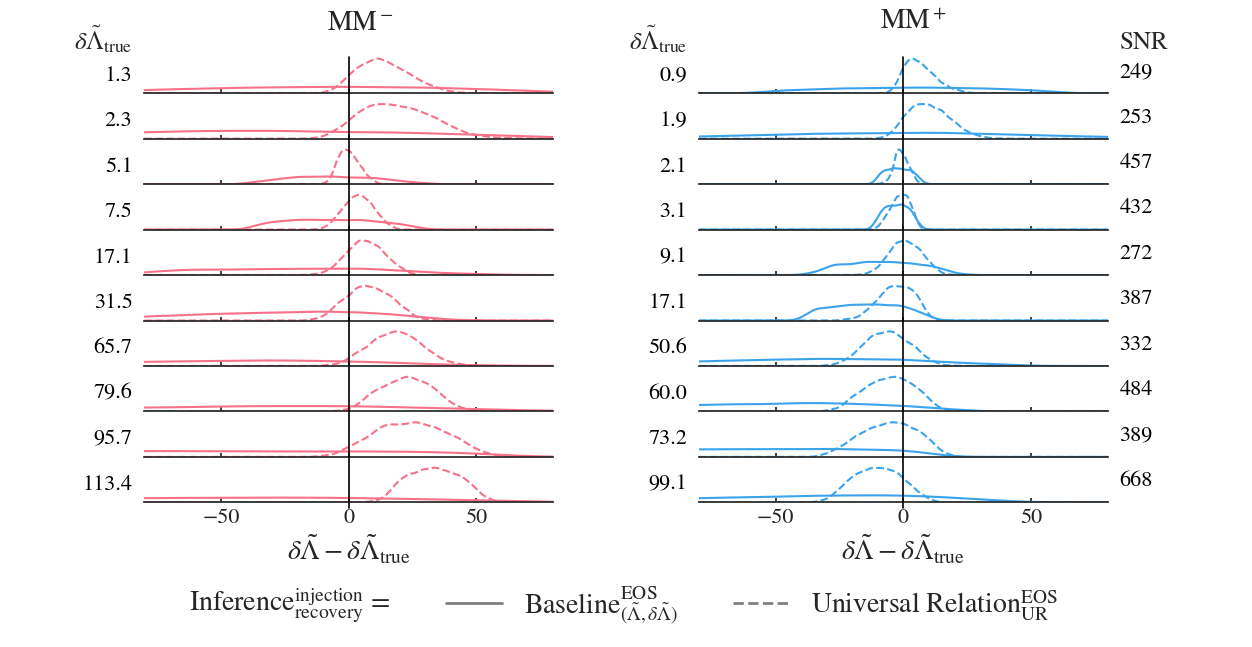

In [ ]:
fs = 24

# --- Style ---
c = sns.husl_palette(3)
sns.set(style='white')
mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "font.size": fs,
})

# --- Parameter and sorting ---
param = 'delta_lambda_tilde'
delta_lambda_values = {
    idx: abs(soft_sampleLa[str(idx)].injection_parameters.get(param, float('nan')))
    for idx in range(10)
}
delta_lambda_values = {k: v for k, v in delta_lambda_values.items() if not np.isnan(v)}
sorted_indices = sorted(delta_lambda_values, key=delta_lambda_values.get)

# --- Figure ---
fig = plt.figure(figsize=(14, len(sorted_indices) * 0.55))
gs = gridspec.GridSpec(
    nrows=len(sorted_indices),
    ncols=5,
    width_ratios=[0.3, 1, 0.3, 1, 0.3],  # soft true, soft post, stiff true, stiff post, SNR
    wspace=0.05
)

# --- Legend ---
legend_elements = [
    Line2D([0], [0], color='grey', lw=2, linestyle='-',
           label=r'Baseline$^{\mathrm{EOS}}_{(\tilde{\Lambda}, \delta\tilde{\Lambda})}$'),
    Line2D([0], [0], color='grey', lw=2, linestyle='--',
           label=r'Universal Relation$^{\mathrm{EOS}}_{\mathrm{UR}}$')
]

# --- KDE x-grid ---
xlim_range = (-80, 80)
x_grid = np.linspace(*xlim_range, 500)

for i, idx in enumerate(sorted_indices):
    idx_str = str(idx)

    # --- Extract data ---
    soft_q = soft_sampleLa[idx_str].posterior[param]
    soft_qur = soft_LaUR[idx_str].posterior[param]
    soft_true = soft_sampleLa[idx_str].injection_parameters[param]

    stiff_q = stiff_sampleLa[idx_str].posterior[param]
    stiff_qur = stiff_LaUR[idx_str].posterior[param]
    stiff_true = stiff_sampleLa[idx_str].injection_parameters[param]

    # --- Center posteriors ---
    soft_q_c = soft_q - soft_true
    soft_qur_c = soft_qur - soft_true
    stiff_q_c = stiff_q - stiff_true
    stiff_qur_c = stiff_qur - stiff_true

    # ===============================
    # Soft true column
    # ===============================
    ax_soft_true = fig.add_subplot(gs[i, 0])
    ax_soft_true.axis('off')
    ax_soft_true.text(
        1.0, 0.5, f"{soft_true:.1f}",
        ha='right', va='center',
        fontsize=fs-8, color='black',
        transform=ax_soft_true.transAxes
    )
    if i == 0:
        ax_soft_true.set_title(
            r'$\delta\tilde{\Lambda}_{\mathrm{true}}$',
            fontsize=fs-6, loc='right'
        )

    # ===============================
    # Soft posterior column
    # ===============================
    ax_soft_post = fig.add_subplot(gs[i, 1])
    for data, style in zip([soft_q_c, soft_qur_c], ['-', '--']):
        kde = gaussian_kde(data)
        y_vals = np.clip(kde(x_grid), 0, None)
        ax_soft_post.plot(
            x_grid, y_vals,
            color=c[0], linewidth=1.5, linestyle=style
        )

    ax_soft_post.set_xlim(xlim_range)
    ax_soft_post.set_ylim(bottom=0)
    ax_soft_post.set_yticks([])
    ax_soft_post.spines['top'].set_visible(False)
    ax_soft_post.spines['right'].set_visible(False)
    ax_soft_post.spines['left'].set_visible(False)

    ax_soft_post.tick_params(
        axis='x', which='both',
        bottom=True, labelsize=fs-8,
        direction='in', length=3
    )

    if i == len(sorted_indices) - 1:
        ax_soft_post.set_xlabel(
            r'$\delta\tilde{\Lambda} - \delta\tilde{\Lambda}_{\mathrm{true}}$',
            fontsize=fs-4
        )
    else:
        ax_soft_post.set_xticklabels([])

    # ===============================
    # Stiff true column
    # ===============================
    ax_stiff_true = fig.add_subplot(gs[i, 2])
    ax_stiff_true.axis('off')
    ax_stiff_true.text(
        1.0, 0.5, f"{stiff_true:.1f}",
        ha='right', va='center',
        fontsize=fs-8, color='black',
        transform=ax_stiff_true.transAxes
    )
    if i == 0:
        ax_stiff_true.set_title(
            r'$\delta\tilde{\Lambda}_{\mathrm{true}}$',
            fontsize=fs-6, loc='right'
        )

    # ===============================
    # Stiff posterior column
    # ===============================
    ax_stiff_post = fig.add_subplot(gs[i, 3])
    for data, style in zip([stiff_q_c, stiff_qur_c], ['-', '--']):
        kde = gaussian_kde(data)
        y_vals = np.clip(kde(x_grid), 0, None)
        ax_stiff_post.plot(
            x_grid, y_vals,
            color=c[2], linewidth=1.5, linestyle=style
        )

    ax_stiff_post.set_xlim(xlim_range)
    ax_stiff_post.set_ylim(bottom=0)
    ax_stiff_post.set_yticks([])
    ax_stiff_post.spines['top'].set_visible(False)
    ax_stiff_post.spines['right'].set_visible(False)
    ax_stiff_post.spines['left'].set_visible(False)

    ax_stiff_post.tick_params(
        axis='x', which='both',
        bottom=True, labelsize=fs-8,
        direction='in', length=3
    )

    if i == len(sorted_indices) - 1:
        ax_stiff_post.set_xlabel(
            r'$\delta\tilde{\Lambda} - \delta\tilde{\Lambda}_{\mathrm{true}}$',
            fontsize=fs-4
        )
    else:
        ax_stiff_post.set_xticklabels([])

    # ===============================
    # SNR column
    # ===============================
    ax_snr = fig.add_subplot(gs[i, 4])
    ax_snr.axis('off')
    cat_idx = int(idx) + 10
    snr_val = catalog.loc[cat_idx, 'SNR']
    ax_snr.text(
        0.0, 0.6, f"{snr_val:.0f}",
        ha='left', va='center',
        fontsize=fs-8, color='black'
    )
    if i == 0:
        ax_snr.set_title('SNR', fontsize=fs-6, loc='left')

# --- Column titles ---
fig.text(0.32, 0.97, "MM$^-$", fontsize=fs-4, ha='center', va='bottom')
fig.text(0.715, 0.97, "MM$^+$", fontsize=fs-4, ha='center', va='bottom')

# --- Legend and inference text ---
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    frameon=False,
    fontsize=fs-4,
    bbox_to_anchor=(0.6, -0.15)
)

fig.text(
    0.27, -0.065,
    r"Inference$^{\mathrm{injection}}_{\mathrm{recovery}}$ =",
    ha='center', va='center',
    fontsize=fs-4
)

# --- Continuous vertical line at 0 ---
for ax in [ax_soft_post, ax_stiff_post]:
    trans = mtransforms.blended_transform_factory(ax.transData, fig.transFigure)
    fig.lines.append(
        plt.Line2D(
            [0, 0], [0.11, 0.93],
            color='black', linewidth=1.2,
            transform=trans, zorder=10
        )
    )

# --- Layout ---
plt.subplots_adjust(
    bottom=0.12,
    top=0.93,
    hspace=0.25,
    left=0.07,
    right=0.95
)

plt.savefig('La_post_pop.pdf', dpi=600, bbox_inches='tight')
plt.show()


In [83]:
param = 'delta_lambda_tilde'

soft_sorted = sorted(
    range(10), 
    key=lambda idx: abs(soft_sampleLa[str(idx)].injection_parameters.get(param, np.nan))
)
stiff_sorted = sorted(
    range(10), 
    key=lambda idx: abs(stiff_sampleLa[str(idx)].injection_parameters.get(param, np.nan))
)

print("Soft order:", soft_sorted)
print("Stiff order:", stiff_sorted)
print("Orders are identical?", soft_sorted == stiff_sorted)

Soft order: [0, 1, 7, 6, 2, 4, 3, 8, 5, 9]
Stiff order: [0, 1, 7, 6, 2, 4, 3, 8, 5, 9]
Orders are identical? True


## $\Lambda$-$f_2$

In [84]:
catalog = pd.read_csv('/work/williams5/testing-urs/bilby/scripts/top_50_fixedQ.csv')
N = 20
maxSNR = np.max(catalog['SNR'])
soft_true = {}
soft_UR = {}
stiff_true = {}
stiff_UR = {}
missing = []
j=0
for i in range(10,20):
    try:
        rundir = f'{baserundir}/samplefUR/EOS_UR/soft/zero-noise'
        label='EOS_UR'
        res_true = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_true)
        soft_true[f'{j}']=res_true

        rundir = f'{baserundir}/samplefUR/EOS_EOS/soft/zero-noise'
        label='EOS_EOS'
        res_UR = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_UR)
        soft_UR[f'{j}']=res_UR

        rundir = f'{baserundir}/samplefUR/EOS_UR/stiff/zero-noise'
        label='EOS_UR'
        res_true = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_true)
        stiff_true[f'{j}']=res_true

        rundir = f'{baserundir}/samplefUR/EOS_EOS/stiff/zero-noise'
        label='EOS_EOS'
        res_UR = bilby.result.read_in_result(filename=f'{rundir}/{i}/{label}_result.json')
        get_lambda_tilde(res_UR)
        stiff_UR[f'{j}']=res_UR
        j+=1
    except:
        print(f'Could not find sample {rundir}/{i}/{label}, please check')
        missing.append(i)
catalog=catalog.drop(missing)

soft_true_zn = soft_true
soft_UR_zn = soft_UR
stiff_true_zn = stiff_true
stiff_UR_zn = stiff_UR

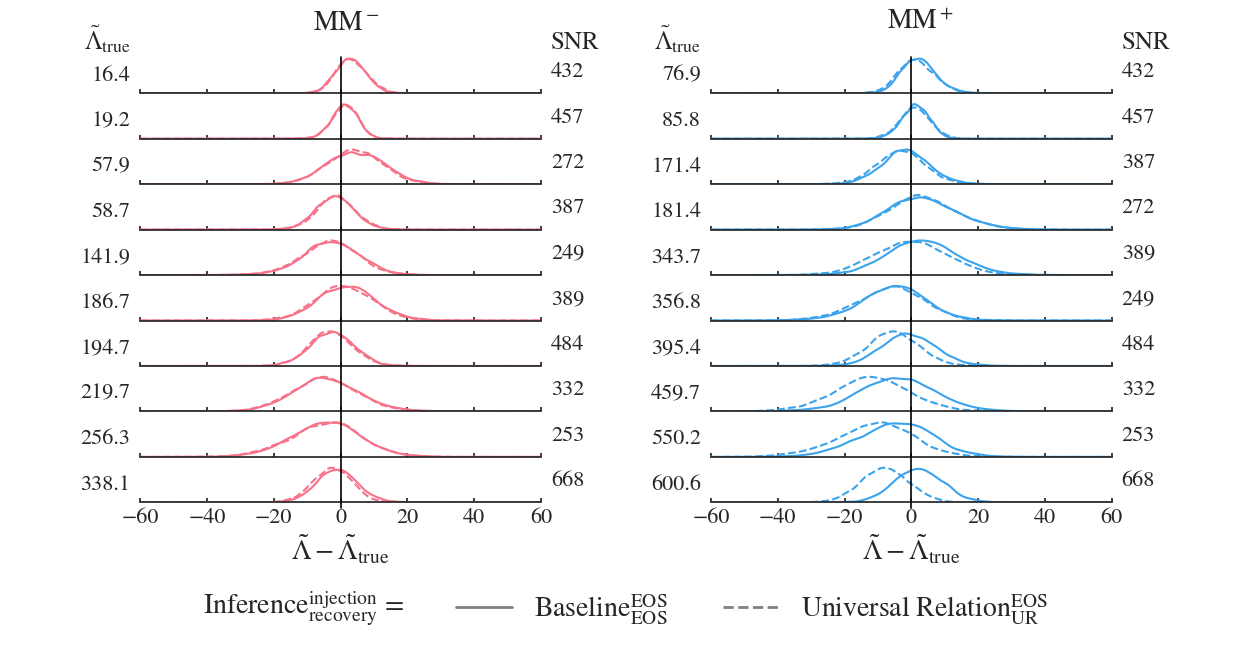

In [ ]:
fs = 24

# ===============================
# Style
# ===============================
c = sns.husl_palette(3)
sns.set(style='white')
mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "font.size": fs,
})

param = 'lambda_tilde'
N = 10

# ===============================
# Sorted indices
# ===============================
soft_values = {
    idx: abs(soft_UR[str(idx)].injection_parameters.get(param, np.nan))
    for idx in range(N)
}
soft_sorted = sorted(soft_values, key=soft_values.get)

stiff_values = {
    idx: abs(stiff_UR[str(idx)].injection_parameters.get(param, np.nan))
    for idx in range(N)
}
stiff_sorted = sorted(stiff_values, key=stiff_values.get)

# ===============================
# Figure
# ===============================
fig = plt.figure(figsize=(14, N * 0.55))
gs = gridspec.GridSpec(
    nrows=N,
    ncols=6,
    width_ratios=[0.3, 1, 0.3, 0.05, 1, 0.3],
    wspace=0.05
)

# ===============================
# Legend
# ===============================
legend_elements = [
    Line2D([0], [0], color='grey', lw=2, linestyle='-',
           label=r'Baseline$^{\mathrm{EOS}}_{\mathrm{EOS}}$'),
    Line2D([0], [0], color='grey', lw=2, linestyle='--',
           label=r'Universal Relation$^{\mathrm{EOS}}_{\mathrm{UR}}$')
]

# ===============================
# KDE grid
# ===============================
xlim_range = (-60, 60)
x_grid = np.linspace(*xlim_range, 500)

for i in range(N):
    soft_idx = soft_sorted[i]
    stiff_idx = stiff_sorted[i]

    # ===============================
    # Soft EOS
    # ===============================
    soft_q = soft_UR[str(soft_idx)].posterior[param]
    soft_qur = soft_true[str(soft_idx)].posterior[param]
    soft_true_val = soft_UR[str(soft_idx)].injection_parameters[param]
    soft_snr = catalog.loc[soft_idx + 10, 'SNR']

    soft_q_c = soft_q - soft_true_val
    soft_qur_c = soft_qur - soft_true_val

    # --- Soft true
    ax_soft_true = fig.add_subplot(gs[i, 0])
    ax_soft_true.axis('off')
    ax_soft_true.text(
        1.0, 0.5, f"{soft_true_val:.1f}",
        ha='right', va='center',
        fontsize=fs-8
    )
    if i == 0:
        ax_soft_true.set_title(
            r'$\tilde{\Lambda}_{\mathrm{true}}$',
            fontsize=fs-6, loc='right'
        )

    # --- Soft posterior
    ax_soft_post = fig.add_subplot(gs[i, 1])
    for data, style in zip([soft_q_c, soft_qur_c], ['-', '--']):
        kde = gaussian_kde(data)
        ax_soft_post.plot(
            x_grid, np.clip(kde(x_grid), 0, None),
            color=c[0], linewidth=1.5, linestyle=style
        )

    ax_soft_post.set_xlim(xlim_range)
    ax_soft_post.set_ylim(bottom=0)
    ax_soft_post.set_yticks([])
    ax_soft_post.spines[['top', 'right', 'left']].set_visible(False)
    ax_soft_post.tick_params(
        axis='x', which='both',
        bottom=True, labelsize=fs-8,
        direction='in', length=3
    )

    if i == N - 1:
        ax_soft_post.set_xlabel(
            r'$\tilde{\Lambda} - \tilde{\Lambda}_{\mathrm{true}}$',
            fontsize=fs-4
        )
    else:
        ax_soft_post.set_xticklabels([])

    # --- Soft SNR
    ax_soft_snr = fig.add_subplot(gs[i, 2])
    ax_soft_snr.axis('off')
    ax_soft_snr.text(
        0.0, 0.6, f"{soft_snr:.0f}",
        ha='left', va='center',
        fontsize=fs-8
    )
    if i == 0:
        ax_soft_snr.set_title('SNR', fontsize=fs-6, loc='left')

    # ===============================
    # Stiff EOS
    # ===============================
    stiff_q = stiff_UR[str(stiff_idx)].posterior[param]
    stiff_qur = stiff_true[str(stiff_idx)].posterior[param]
    stiff_true_val = stiff_UR[str(stiff_idx)].injection_parameters[param]
    stiff_snr = catalog.loc[stiff_idx + 10, 'SNR']

    stiff_q_c = stiff_q - stiff_true_val
    stiff_qur_c = stiff_qur - stiff_true_val

    # --- Stiff true
    ax_stiff_true = fig.add_subplot(gs[i, 3])
    ax_stiff_true.axis('off')
    ax_stiff_true.text(
        1.0, 0.5, f"{stiff_true_val:.1f}",
        ha='right', va='center',
        fontsize=fs-8
    )
    if i == 0:
        ax_stiff_true.set_title(
            r'$\tilde{\Lambda}_{\mathrm{true}}$',
            fontsize=fs-6, loc='right'
        )

    # --- Stiff posterior
    ax_stiff_post = fig.add_subplot(gs[i, 4])
    for data, style in zip([stiff_q_c, stiff_qur_c], ['-', '--']):
        kde = gaussian_kde(data)
        ax_stiff_post.plot(
            x_grid, np.clip(kde(x_grid), 0, None),
            color=c[2], linewidth=1.5, linestyle=style
        )

    ax_stiff_post.set_xlim(xlim_range)
    ax_stiff_post.set_ylim(bottom=0)
    ax_stiff_post.set_yticks([])
    ax_stiff_post.spines[['top', 'right', 'left']].set_visible(False)
    ax_stiff_post.tick_params(
        axis='x', which='both',
        bottom=True, labelsize=fs-8,
        direction='in', length=3
    )

    if i == N - 1:
        ax_stiff_post.set_xlabel(
            r'$\tilde{\Lambda} - \tilde{\Lambda}_{\mathrm{true}}$',
            fontsize=fs-4
        )
    else:
        ax_stiff_post.set_xticklabels([])

    # --- Stiff SNR
    ax_stiff_snr = fig.add_subplot(gs[i, 5])
    ax_stiff_snr.axis('off')
    ax_stiff_snr.text(
        0.0, 0.6, f"{stiff_snr:.0f}",
        ha='left', va='center',
        fontsize=fs-8
    )
    if i == 0:
        ax_stiff_snr.set_title('SNR', fontsize=fs-6, loc='left')

# ===============================
# Column titles
# ===============================
fig.text(0.31, 0.97, "MM$^-$", fontsize=fs-4, ha='center', va='bottom')
fig.text(0.72, 0.97, "MM$^+$", fontsize=fs-4, ha='center', va='bottom')

# ===============================
# Legend and inference text
# ===============================
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    frameon=False,
    fontsize=fs-4,
    bbox_to_anchor=(0.6, -0.15)
)

fig.text(
    0.28, -0.07,
    r"Inference$^{\mathrm{injection}}_{\mathrm{recovery}}$ =",
    ha='center', va='center',
    fontsize=fs-4
)

# ===============================
# Vertical reference lines
# ===============================
for ax in [ax_soft_post, ax_stiff_post]:
    trans = mtransforms.blended_transform_factory(ax.transData, fig.transFigure)
    fig.lines.append(
        plt.Line2D(
            [0, 0], [0.11, 0.93],
            color='black', linewidth=1.2,
            transform=trans, zorder=10
        )
    )

# ===============================
# Layout
# ===============================
plt.subplots_adjust(
    bottom=0.12,
    top=0.93,
    hspace=0.25,
    left=0.07,
    right=0.95
)

plt.savefig('fund_mode_freq_post_pop.pdf', dpi=600, bbox_inches='tight')
plt.show()
